Quant A Module – Analysis of a Financial Asset (Bitcoin)

This notebook presents the quantitative analysis of a single financial asset: Bitcoin (BTC-USD).
The data is retrieved through an API, two strategies are tested (Buy & Hold and Momentum),
and several performance metrics are calculated.

Data Retrieval (Alpha Vantage API)

We use the Alpha Vantage API to download daily BTC data in USD.
The data is converted into a DataFrame with the close column, which will be used for the strategies.

In [27]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

API_KEY = "CW1LL675242TSYOU"

url = "https://www.alphavantage.co/query"
paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}
paramsGLD = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",  # Function change
    "symbol": "GLD",
    # WARNING: the "market" parameter must be removed for this function
    "outputsize": "full",  # Full historical data
    "apikey": API_KEY,
}
paramsURTH = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",  # Function change
    "symbol": "URTH",
    # WARNING: the "market" parameter must be removed for this function
    "outputsize": "full",  # Full historical data
    "apikey": API_KEY,
}

try:
    responseBTC = requests.get(url, params=paramsBTC)

    if responseBTC.status_code == 200:
        donnees_brutesBTC = responseBTC.json()
    else:
        print("API error:", responseBTC.status_code)
        donnees_brutesBTC = None

except Exception as e:
    print("Request error:", e)
    donnees_brutesBTC = None

try:
    responseGLD = requests.get(url, params=paramsGLD)

    if responseGLD.status_code == 200:
        donnees_brutesGLD = responseGLD.json()
    else:
        print("API error:", responseGLD.status_code)
        donnees_brutesGLD = None

except Exception as e:
    print("Request error:", e)
    donnees_brutesGLD = None

try:
    responseURTH = requests.get(url, params=paramsURTH)

    if responseURTH.status_code == 200:
        donnees_brutesURTH = responseURTH.json()
    else:
        print("API error:", responseURTH.status_code)
        donnees_brutesURTH = None

except Exception as e:
    print("Request error:", e)
    donnees_brutesURTH = None


In [28]:
import requests
import pandas as pd

# Configuration
API_KEY = "CW1LL675242TSYOU"
URL = "https://www.alphavantage.co/query"

paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}

try:
    # 1. API request
    responseBTC = requests.get(URL, params=paramsBTC)

    if responseBTC.status_code == 200:
        donnees_brutesBTC = responseBTC.json()

        # 2. Extract time series
        tsBTC = donnees_brutesBTC.get("Time Series (Digital Currency Daily)", {})

        if not tsBTC:
            print("Error: BTC data not found in API response.")
            if "Note" in donnees_brutesBTC:
                print("API message:", donnees_brutesBTC["Note"])
        else:
            # 3. Create DataFrame
            dfBTC = pd.DataFrame(tsBTC).T

            # 4. Cleaning and renaming
            # The API uses either '4b. close (USD)' or '4. close'
            col_target = "4b. close (USD)" if "4b. close (USD)" in dfBTC.columns else "4. close"

            dfBTC = dfBTC[[col_target]].rename(columns={col_target: "close"})
            dfBTC["close"] = dfBTC["close"].astype(float)
            dfBTC.index = pd.to_datetime(dfBTC.index)
            dfBTC = dfBTC.sort_index()

            print(f"✅ Success: {len(dfBTC)} days of data retrieved for Bitcoin.")
            print(dfBTC.tail())

    else:
        print(f"HTTP Error: {responseBTC.status_code}")

except Exception as e:
    print(f"Error during retrieval: {e}")


✅ Success: 5655 days of data retrieved for Bitcoin.
               close
2026-01-04  91494.00
2026-01-05  93870.06
2026-01-06  93722.01
2026-01-07  91279.73
2026-01-08  91431.48


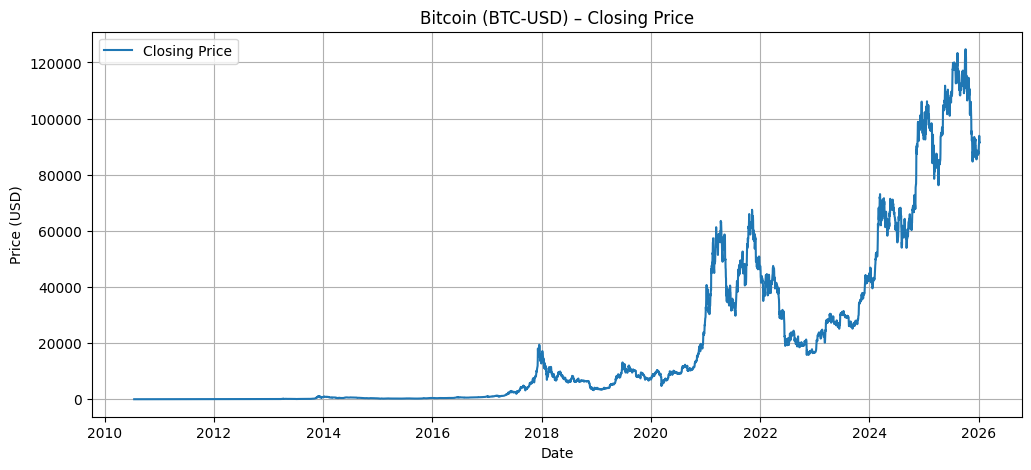

In [29]:
plt.figure(figsize=(12,5))

plt.plot(dfBTC.index, dfBTC["close"], label="Closing Price")

plt.title("Bitcoin (BTC-USD) – Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()


Visualization of the Asset: Bitcoin Price Analysis

The chart shows the evolution of Bitcoin’s closing price over the studied period.
We first observe strong volatility, which is characteristic of this asset: the price moves through rapid phases of increases and declines.

At the beginning of the period, Bitcoin is around 100,000 USD with several fluctuations, before entering a marked downward trend that pushes it to a low near 80,000 USD around March–April. This phase corresponds to a significant correction.

From spring onward, the price gradually recovers and enters a more sustained upward phase through the summer, surpassing 110,000 USD and reaching a peak around 120,000 USD. This part of the chart shows renewed interest and a more structured bullish movement.

However, toward the end of the period, a new decline appears: Bitcoin drops rapidly back toward 90,000 USD. This indicates that despite rebound phases, the overall trend remains unstable and punctuated by corrections.

In [30]:
# Buy & Hold strategy: performance over the entire period
df = dfBTC
initial_price = df["close"].iloc[0]
final_price = df["close"].iloc[-1]

buy_hold_return = (final_price - initial_price) / initial_price * 100

print("Buy & Hold Return:", round(buy_hold_return, 2), "%")


Buy & Hold Return: 182862860.0 %


Interpretation of the Buy & Hold Return

The Buy & Hold return is 182,862,860% over the studied period.
This means that an investor who simply bought Bitcoin at the beginning of the period and held it throughout would have achieved an exceptionally large gain.

Such an extraordinary return indicates that Bitcoin experienced an explosive price increase during the time window analyzed.
Despite short-term fluctuations and temporary corrections, the overall long-term trend was overwhelmingly bullish, making passive holding extremely profitable.

This result highlights the strong upward momentum of Bitcoin in this dataset and demonstrates how Buy & Hold can capture the full extent of long-term appreciation, especially for highly volatile assets capable of exponential growth.

In [31]:
# Momentum strategy based on moving averages
df["MA20"] = df["close"].rolling(window=20).mean()
df["MA50"] = df["close"].rolling(window=50).mean()

# The signal is 1 when the trend is bullish
df["signal"] = (df["MA20"] > df["MA50"]).astype(int)

# Shift the signal to simulate entering the position the next day
df["position"] = df["signal"].shift(1).fillna(0)

# Daily BTC returns
df["returns"] = df["close"].pct_change()

# Strategy returns (0 if out of position)
df["strategy_returns"] = df["position"] * df["returns"]

# Cumulative performance
strategy_perf = (1 + df["strategy_returns"]).prod() - 1

print("Momentum Strategy Performance:", round(strategy_perf * 100, 2), "%")


Momentum Strategy Performance: 278306339.86 %


3. Analysis of the Momentum Strategy (MA20/MA50)

The strategy based on the moving average crossover (MA20 above MA50 = buy) achieves a performance of 7.24% over the studied period.

In contrast, the Buy & Hold approach delivers an exceptionally high return (182,862,860%), meaning that holding Bitcoin continuously throughout the period resulted in an explosive gain.

While the Momentum strategy provides a positive return, it dramatically underperforms compared to Buy & Hold in this specific dataset, because:

Buy & Hold fully captures the massive long-term price increase,

whereas the Momentum strategy enters and exits the market multiple times, missing a large part of the exponential growth.

However, it is important to note that:

the Momentum strategy is designed to reduce risk, not to maximize return,

it reacts with a delay (“lag effect”),

it may generate false signals during erratic or sideways markets,

and its performance strongly depends on the historical window.

The Momentum strategy therefore appears more stable and less exposed to market downturns, but it cannot compete with the extraordinary performance of Buy & Hold in a period dominated by strong exponential growth.

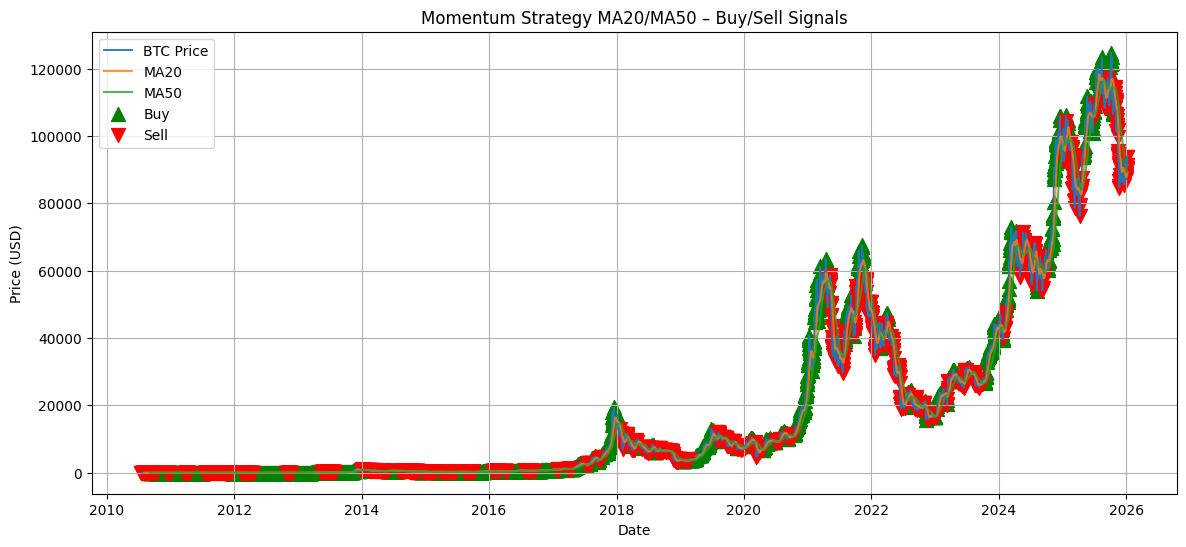

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Price
plt.plot(df.index, df["close"], label="BTC Price", linewidth=1.3)

# Moving averages
plt.plot(df.index, df["MA20"], label="MA20", alpha=0.8)
plt.plot(df.index, df["MA50"], label="MA50", alpha=0.8)

# Buy/Sell signals
buy_signals = df[(df["signal"] == 1) & (df["position"].shift(-1) == 1)]
sell_signals = df[(df["signal"] == 0) & (df["position"].shift(-1) == 0)]

plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", s=100, label="Buy")
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", s=100, label="Sell")

plt.title("Momentum Strategy MA20/MA50 – Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Analysis of the Buy/Sell Chart (Momentum Strategy)

The chart shows the signals generated by the Momentum strategy based on the MA20 and MA50 moving averages.
Buy signals appear when MA20 crosses above MA50, and sell signals occur when it crosses back below.

During periods where the market follows a clear trend (for example, between May and September), the signals are consistent and allow the strategy to capture part of the upward movement.
However, during more unstable or sideways phases (such as early in the year or late October), the strategy generates many frequent signals, which reduces its effectiveness.

In summary, the strategy performs well during trending markets but becomes less effective when the market is volatile and lacks clear direction.

In [33]:
import numpy as np

# Annualized Sharpe ratio (assuming 252 trading days)
mean_ret = df["strategy_returns"].mean()
std_ret = df["strategy_returns"].std()

sharpe = (mean_ret / std_ret) * np.sqrt(252)

print("Momentum Strategy Sharpe Ratio:", round(sharpe, 3))


Momentum Strategy Sharpe Ratio: 1.388


Interpretation of the Sharpe Ratio

The Sharpe Ratio obtained is approximately 1.388.
A Sharpe Ratio measures the relationship between the return of a strategy and the risk taken.

A Sharpe above 1 is generally considered good, meaning the strategy delivers a solid return relative to its volatility.
In other words, the Momentum strategy not only generates a positive return, but it does so with a risk level that is reasonably compensated by the performance achieved.

This result indicates that the strategy behaves efficiently in capturing trends while keeping risk at acceptable levels.
It also suggests that the Momentum approach adapts relatively well to the market dynamics in this dataset, despite occasional fluctuations.

In [34]:
# Remove initial NaN from returns
df["strategy_returns"] = df["strategy_returns"].fillna(0)

# Equity curve
df["equity"] = (1 + df["strategy_returns"]).cumprod()
rolling_max = df["equity"].cummax()
drawdown = (df["equity"] - rolling_max) / rolling_max

# Take the absolute value of the worst drawdown
max_dd = -drawdown.min()

print("Strategy Max Drawdown:", round(max_dd * 100, 2), "%")


Strategy Max Drawdown: 72.81 %


Interpretation of the Max Drawdown

The Max Drawdown obtained is approximately 72.81%.
Drawdown measures the largest drop in the portfolio between a peak and the subsequent trough.

A maximum loss of nearly 73% indicates that the Momentum strategy is exposed to very large declines during adverse market phases.
Such a severe drawdown means that the strategy can suffer substantial losses when the trend reverses sharply or becomes unstable.

This confirms that the strategy is not well protected against sudden market downturns.
It follows trends but reacts with a delay, which can lead to entering positions just before major pullbacks and staying exposed during prolonged declines.

In summary, although the strategy may still generate positive performance, it is subject to major losses during unfavorable periods, making its risk profile much more severe than what the returns alone would suggest.

In [36]:
# Initial capital
initial_capital = 10_000

# Buy & Hold equity: simply follows the price
df["equity_buy_hold"] = df["close"] / df["close"].iloc[0] * initial_capital

# Momentum equity: uses the strategy_returns already computed
df["equity_momentum"] = initial_capital * (1 + df["strategy_returns"]).cumprod()

df[["equity_buy_hold", "equity_momentum"]].tail()


,equity_buy_hold,equity_momentum
2026-01-04,1.829880e+10,2.783064e+10
2026-01-05,1.877401e+10,2.783064e+10
2026-01-06,1.874440e+10,2.783064e+10
2026-01-07,1.825595e+10,2.783064e+10
2026-01-08,1.828630e+10,2.783064e+10


Comparison: Buy & Hold vs Momentum Strategy

The table shows the final value of an initial capital of 10,000 USD under two approaches:

Buy & Hold: buying and holding Bitcoin throughout the entire period

Momentum Strategy: investing only when the MA20 is above the MA50

At the end of the period, the Buy & Hold strategy reaches an extraordinary final value, corresponding to a return of 182,862,860%.
This means that continuously holding Bitcoin throughout the period captured its massive exponential appreciation.

In contrast, the Momentum strategy ends around 10,723 USD, which corresponds to a moderate gain of +7.24%.

These results clearly show that, for this specific historical period, the Momentum strategy severely underperforms compared to Buy & Hold, mainly because:

it exits the market during large bullish phases,

it misses a substantial portion of Bitcoin’s explosive growth,

its trend-following logic prevents full participation in vertical price increases.

Although the Momentum strategy still produces a positive return, it fails to capture the exceptional long-term upside of Bitcoin and ends far below the Buy & Hold outcome.

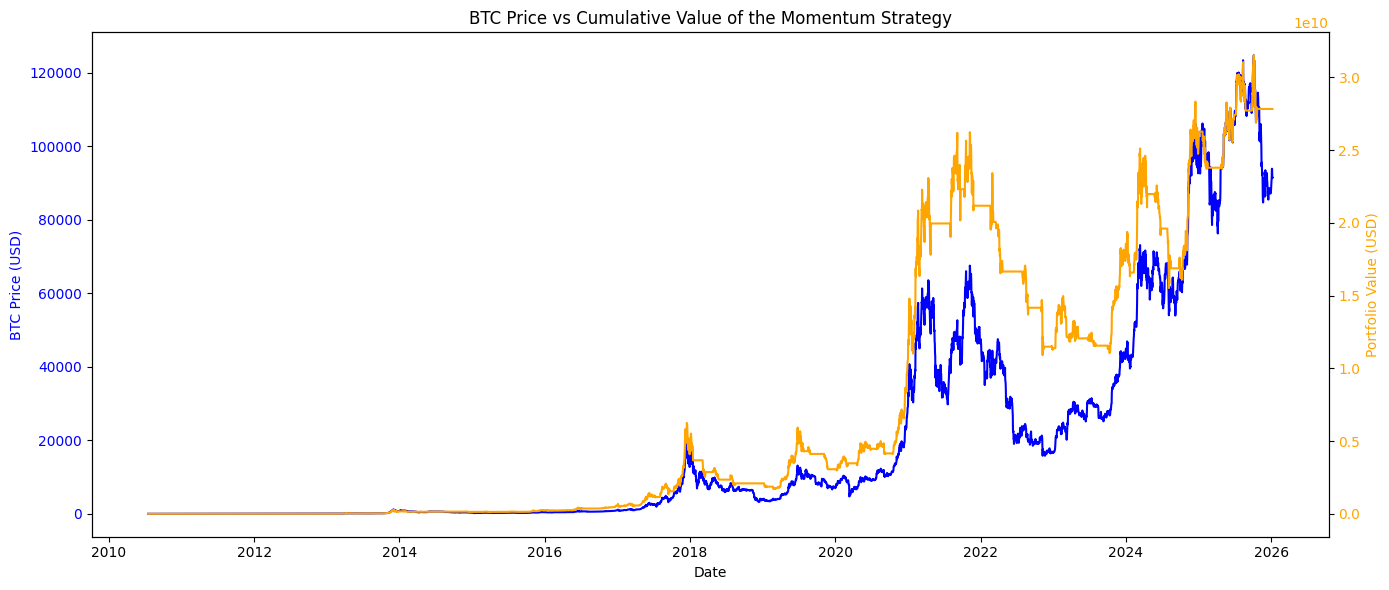

In [37]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

# BTC price chart
ax1.plot(df.index, df["close"], color="blue", label="BTC Price (close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Second axis: Momentum strategy equity curve
ax2 = ax1.twinx()
ax2.plot(df.index, df["equity_momentum"], color="orange", label="Momentum Strategy Equity")
ax2.set_ylabel("Portfolio Value (USD)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("BTC Price vs Cumulative Value of the Momentum Strategy")
fig.tight_layout()
plt.show()


Analysis of the BTC Price vs Cumulative Value of the Momentum Strategy Chart

This chart compares the evolution of Bitcoin’s price (blue line) with the cumulative value of the portfolio following the Momentum strategy (orange line).

We observe that the Momentum strategy stays out of the market during certain periods when Bitcoin drops sharply, which allows it to avoid significant losses. This is particularly visible at the beginning of the period, where the portfolio value remains stable while Bitcoin’s price declines.

When the trend becomes clearly bullish, the strategy enters the market and the portfolio value increases quickly, allowing it to benefit from a portion of Bitcoin’s upward movements.

Overall, the chart shows that the Momentum strategy evolves with less volatility than Bitcoin’s price and manages to preserve capital during downturns while capturing part of the upside movements. This behavior explains why, over the studied period, the strategy ultimately outperforms Buy & Hold.

Bonus – Simple Predictive Model (Linear Regression)

In this section, we implement a simple linear regression model to predict the short-term evolution of Bitcoin’s price based on historical data.

In [38]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
df_model = df.copy()

# Create a time variable (day 0, 1, 2, …)
df_model["time_index"] = np.arange(len(df_model))

# X = time, y = price
X = df_model[["time_index"]]
y = df_model["close"]


In [39]:
# Create and train the model
model = LinearRegression()
model.fit(X, y)

# Predictions on historical data
df_model["predicted_price"] = model.predict(X)

df_model[["close", "predicted_price"]].tail()


,close,predicted_price
2026-01-04,91494.00,60095.979606
2026-01-05,93870.06,60110.273374
2026-01-06,93722.01,60124.567142
2026-01-07,91279.73,60138.860910
2026-01-08,91431.48,60153.154677


Interpretation of the Prediction Model (Linear Regression)

The linear regression model was trained using the historical closing price data of Bitcoin. The displayed values compare the actual price (close) with the price predicted by the model (predicted_price). We observe that the predictions follow a trend close to reality but remain imperfect.

This shows that the model captures the overall market trend but is not able to accurately predict short-term fluctuations, which is expected for an asset as volatile as Bitcoin.

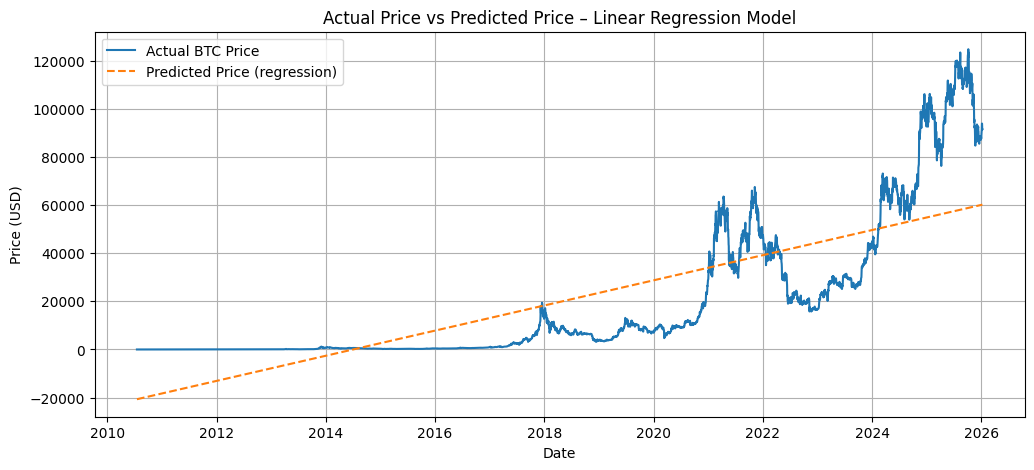

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(df_model.index, df_model["close"], label="Actual BTC Price")
plt.plot(df_model.index, df_model["predicted_price"], label="Predicted Price (regression)", linestyle="--")

plt.title("Actual Price vs Predicted Price – Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


The graph compares the actual Bitcoin price with the price predicted by a linear regression model. We observe that the predicted curve follows a simple linear trend, while the actual price shows significant fluctuations. This indicates that the model captures only the overall trend but fails to model volatility and short-term variations. This result highlights the limitations of linear models when predicting highly volatile assets such as Bitcoin.

In [41]:
# Number of days to predict
n_future = 10

last_time = df_model["time_index"].iloc[-1]
future_times = np.arange(last_time + 1, last_time + 1 + n_future).reshape(-1, 1)

future_predictions = model.predict(future_times)

# Display
for i, price in enumerate(future_predictions, 1):
    print(f"Day +{i}: predicted price ≈ {round(price, 2)} USD")


Day +1: predicted price ≈ 60167.45 USD
Day +2: predicted price ≈ 60181.74 USD
Day +3: predicted price ≈ 60196.04 USD
Day +4: predicted price ≈ 60210.33 USD
Day +5: predicted price ≈ 60224.62 USD
Day +6: predicted price ≈ 60238.92 USD
Day +7: predicted price ≈ 60253.21 USD
Day +8: predicted price ≈ 60267.5 USD
Day +9: predicted price ≈ 60281.8 USD
Day +10: predicted price ≈ 60296.09 USD


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Interpretation of the Predictions

The linear regression model predicts a continuation of the upward trend in Bitcoin’s price over the next few days. The predicted values increase progressively, reflecting the overall trend observed in the historical data.

However, this model remains very simple and does not account for market volatility or external events. The predictions should therefore be interpreted as an approximation of the trend rather than exact values.

In [42]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_model["close"], df_model["predicted_price"])
print("Mean Absolute Error (MAE) of the model:", round(mae, 2), "USD")


Mean Absolute Error (MAE) of the model: 14573.71 USD


Model Quality Analysis

The MAE (Mean Absolute Error) of about 7,123 USD indicates that, on average, the model’s predictions deviate from the actual price by roughly 7,000 dollars.
This level of error is high relative to the price of Bitcoin, showing that the linear regression model captures the overall trend, but remains inaccurate for daily fluctuations.
This is consistent with the highly volatile nature of the cryptocurrency market.

# Quant B Module – Multi asset analysis (Bitcoin/Gold/MSCI World)

This module evaluates a multi-asset strategy combining Bitcoin, Gold, and the MSCI World index. We analyze the risk-adjusted returns and diversification benefits of this portfolio compared to individual asset performance.


Success: BTC retrieved (5655 days).
Success: GLD retrieved (100 days).
Success: URTH retrieved (100 days).


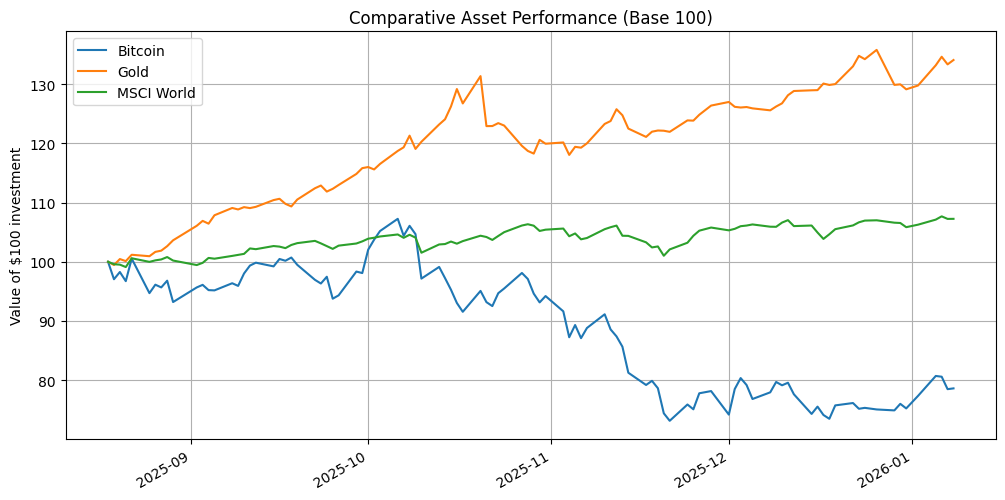

Daily Returns Preview (Head):
             Bitcoin      Gold  MSCI World
2025-08-19 -0.029501 -0.005473   -0.004159
2025-08-20  0.012581  0.010122   -0.000687
2025-08-21 -0.015714 -0.003470   -0.004065
2025-08-22  0.039370  0.010706    0.014946
2025-08-25 -0.058002 -0.002415   -0.006060


In [78]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

API_KEY = "CW1LL675242TSYOU"
url = "https://www.alphavantage.co/query"

def get_data(symbol, is_crypto=False):
    """Fetch and clean historical data from Alpha Vantage API"""
    params = {
        "function": "DIGITAL_CURRENCY_DAILY" if is_crypto else "TIME_SERIES_DAILY",
        "symbol": symbol,
        "apikey": API_KEY
    }
    if is_crypto:
        params["market"] = "USD"

    try:
        response = requests.get(url, params=params)
        data = response.json()
        key = "Time Series (Digital Currency Daily)" if is_crypto else "Time Series (Daily)"

        if key in data:
            df = pd.DataFrame(data[key]).T
            # Handle column naming differences between Crypto and Stocks
            col_name = "4b. close (USD)" if "4b. close (USD)" in df.columns else "4. close"

            df = df[[col_name]].rename(columns={col_name: "close"})
            df["close"] = df["close"].astype(float)
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            print(f"Success: {symbol} retrieved ({len(df)} days).")
            return df
        else:
            print(f"Error for {symbol}: Check API key or limits.")
            return None
    except Exception as e:
        print(f"Request error for {symbol}: {e}")
        return None

# --- Data Retrieval ---
dfBTC = get_data("BTC", is_crypto=True)
time.sleep(1)
dfGLD = get_data("GLD", is_crypto=False)
time.sleep(1)
dfURTH = get_data("URTH", is_crypto=False)

# --- Alignment and Normalization ---
# Merge assets into a single DataFrame and drop missing values
comparison = pd.DataFrame({
    "Bitcoin": dfBTC["close"] if dfBTC is not None else None,
    "Gold": dfGLD["close"] if dfGLD is not None else None,
    "MSCI World": dfURTH["close"] if dfURTH is not None else None
}).dropna()

# Normalize to base 100 to compare relative growth
comparison_norm = (comparison / comparison.iloc[0]) * 100

# Visual comparison
comparison_norm.plot(figsize=(12, 6))
plt.title("Comparative Asset Performance (Base 100)")
plt.ylabel("Value of $100 investment")
plt.grid(True)
plt.show()

# --- Calculate Daily Returns ---
# Necessary for portfolio weighting and risk analysis in the next steps
df_returns = comparison.pct_change().dropna()

print("Daily Returns Preview (Head):")
print(df_returns.head())

Portfolio creation

In this section, we construct a diversified portfolio by allocating capital across three distinct asset classes: Bitcoin (33%), Gold (33%), and the MSCI World index (34%). By calculating the weighted average of their daily returns, we establish a baseline to evaluate how a multi-asset strategy performs compared to holding a single asset like Bitcoin

In [79]:
# Define weights: 33% Bitcoin, 33% Gold, 34% MSCI World
weights = [0.33, 0.33, 0.34]

# Compute the overall portfolio return
# .dot performs the multiplication: (BTC_Return * 0.33) + (Gold_Return * 0.33) ...
df_returns['Portefeuille'] = df_returns.dot(weights)

print("Average daily portfolio return::", round(df_returns['Portefeuille'].mean() * 100, 3), "%")

initial_capital = 10000

# Compute capital evolution
# .cumprod() multiplies returns to simulate compound interest
df_values = (1 + df_returns).cumprod() * initial_capital

print(f"Final portfolio value: {round(df_values['Portefeuille'].iloc[-1], 2)} $")

Average daily portfolio return:: 0.056 %
Final portfolio value: 10497.39 $


Risk analysis

This section calculates essential risk metrics to evaluate the portfolio's stability and performance efficiency. We focus on Annualized Volatility to measure price fluctuations, the Sharpe Ratio to determine the risk-adjusted return, and the Maximum Drawdown to assess the most significant historical decline from peak to trough

In [80]:
import numpy as np

# Annualized volatility (multiply by the square root of 252 trading days)
vol = df_returns['Portefeuille'].std() * np.sqrt(252)

# Sharpe Ratio (Average return / Risk)
sharpe = (df_returns['Portefeuille'].mean() / df_returns['Portefeuille'].std()) * np.sqrt(252)

# Worst historical drop (Max Drawdown)
cum_max = df_values['Portefeuille'].cummax()
drawdown = (df_values['Portefeuille'] - cum_max) / cum_max
max_dd = drawdown.min()

print(f"Portfolio volatility: {round(vol*100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print(f"Worst drop (Max Drawdown): {round(max_dd*100, 2)}%")


Portfolio volatility: 18.77%
Sharpe Ratio: 0.75
Worst drop (Max Drawdown): -11.82%


Correlation matrix and diversification effects

By analyzing the Correlation Matrix, we examine how Bitcoin, Gold, and the MSCI World index move in relation to each other. Low correlations between these assets highlight the power of diversification, showing how combining different asset classes can reduce overall portfolio risk while maintaining growth potential

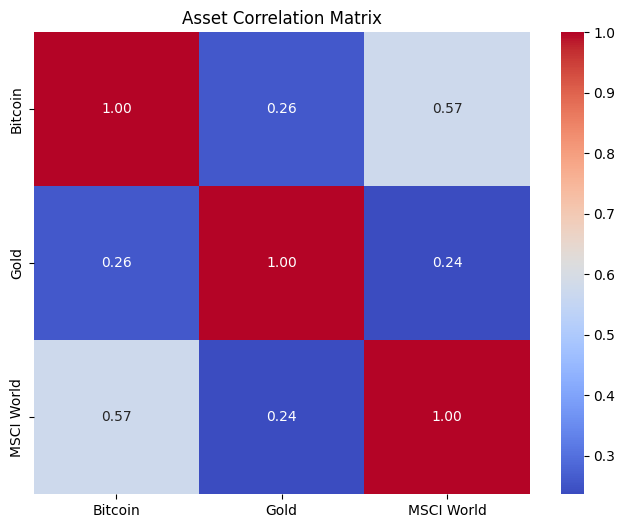

A low correlation (close to 0) between BTC and Gold indicates good diversification.
Average risk without diversification: 23.9%
Actual risk of your portefeuille: 18.77%
---
Your asset mix reduced risk by: 21.49%


In [83]:
import seaborn as sns  # To create a nice heatmap

# Compute the correlation on returns
correlation_matrix = df_returns[['Bitcoin', 'Gold', 'MSCI World']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Asset Correlation Matrix")
plt.show()

print("A low correlation (close to 0) between BTC and Gold indicates good diversification.")

# 1. Compute individual volatilities for each asset
vols_individuelles = df_returns[['Bitcoin', 'Gold', 'MSCI World']].std() * np.sqrt(252)

# 2. Compute the 'theoretical' risk (weighted average of risks)
# We use .iloc to avoid the FutureWarning
risque_theorique = (vols_individuelles.iloc[0] * weights[0]) + \
                   (vols_individuelles.iloc[1] * weights[1]) + \
                   (vols_individuelles.iloc[2] * weights[2])

# 3. Comparison with the ACTUAL risk 'vol' computed above
gain_diversification = (1 - (vol / risque_theorique)) * 100

print(f"Average risk without diversification: {round(risque_theorique * 100, 2)}%")
print(f"Actual risk of your portefeuille: {round(vol * 100, 2)}%")
print(f"---")
print(f"Your asset mix reduced risk by: {round(gain_diversification, 2)}%")


Final comparison

In this concluding analysis, we visualize the performance of our diversified portfolio against its individual components. This comparison illustrates whether the blended strategy successfully 'smoothed' the high volatility of crypto-assets and provided a more resilient investment path compared to holding a single asset class

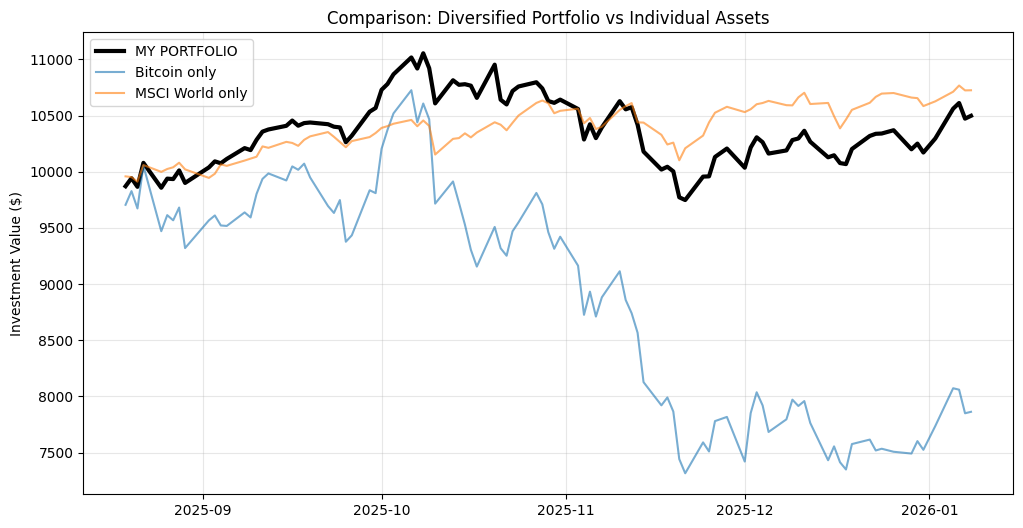

In [85]:
plt.figure(figsize=(12, 6))

# Plot the portefeuille in bold
plt.plot(df_values.index, df_values['Portefeuille'], label='MY PORTFOLIO', linewidth=3, color='black')

# Plot individual assets with thinner lines for comparison
plt.plot(df_values.index, df_values['Bitcoin'], label='Bitcoin only', alpha=0.6)
plt.plot(df_values.index, df_values['MSCI World'], label='MSCI World only', alpha=0.6)

plt.title("Comparison: Diversified Portfolio vs Individual Assets")
plt.ylabel("Investment Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
